# Bias in EuroSAT

The EuroSAT dataset is a land-cover satellite image classification use-case on 13 spectral bands consisting on 10 classes and containing 27000 labeled and geo-referenced examples. As we will be placing ourselves in the *fairness* frame of work, we will be simplyfying our problem to a Highway/River binary classification problem, where we also know that a small percentage of images (~3\% of the whole dataset) has a certain blue-veiled property. As we will prove later, this group of images constitutes a discriminated group in the sense of the equality of odds/errors.
To identify these images, we will transform the images to the HSV color-space, and use custom thresholds in the mean of each channel to flag each image as either discriminated (blue-veiled, S=0) or not (S=1). In particular, we fix this threshold at 0.35 for the saturation channel, 0.4 for the value, and verify that the hue's value is between 210 and 270. With this information, we can calculate some statistics about the dataset.

## Imports

In [1]:
# General Imports
import plotly.express as px

# Augmentare Imports
from utils import plot_wrong_pred, plot_bar_err_rate, plot_loss_acc_train,\
                plot_bar_acc_simu_simple, plot_err_rate_simu_simple,\
                plot_bar_acc_simu_double, plot_err_rate_simu_double,\
                plot_err_rate_test, plot_acc_test, plot_err_rate_test_double,\
                plot_heatmap_accuracy, plot_heatmap_err_rate,\
                average_seeds, get_acc_err_rate, get_dataframe

/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_path = "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/Exp/Output_ResNet18"

## Simulation with FDA

First we will test the FDA neural type transfer method. We will test the model Resnet18 with the blue highway and blue river images pairs added to the original Dataset.

In [3]:
nbs_highway = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
nbs_river = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]

In [4]:
path = "/home/vuong.nguyen/vuong/augmentare/Bias in EuroSAT/NST_output/FDA/ResNet18"
accuracy, error_rate = average_seeds(path=path, nb_seeds=10)

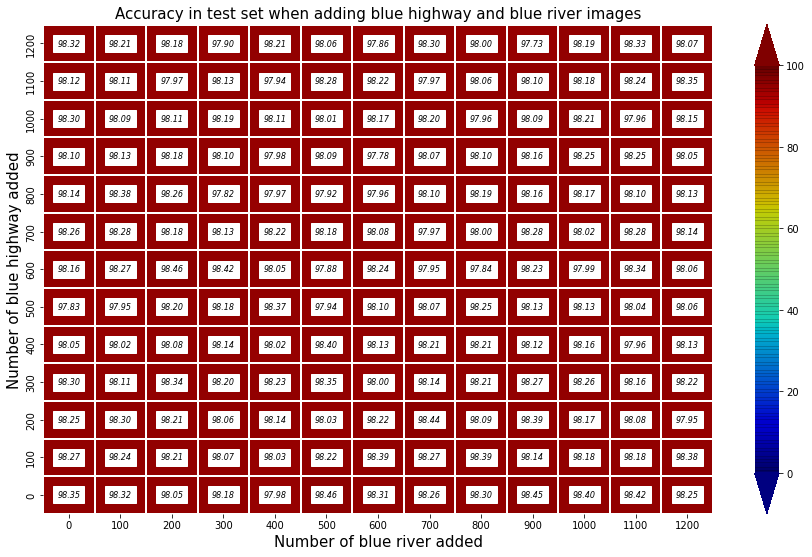

In [5]:
plot_heatmap_accuracy(accuracy, nbs_highway, nbs_river)

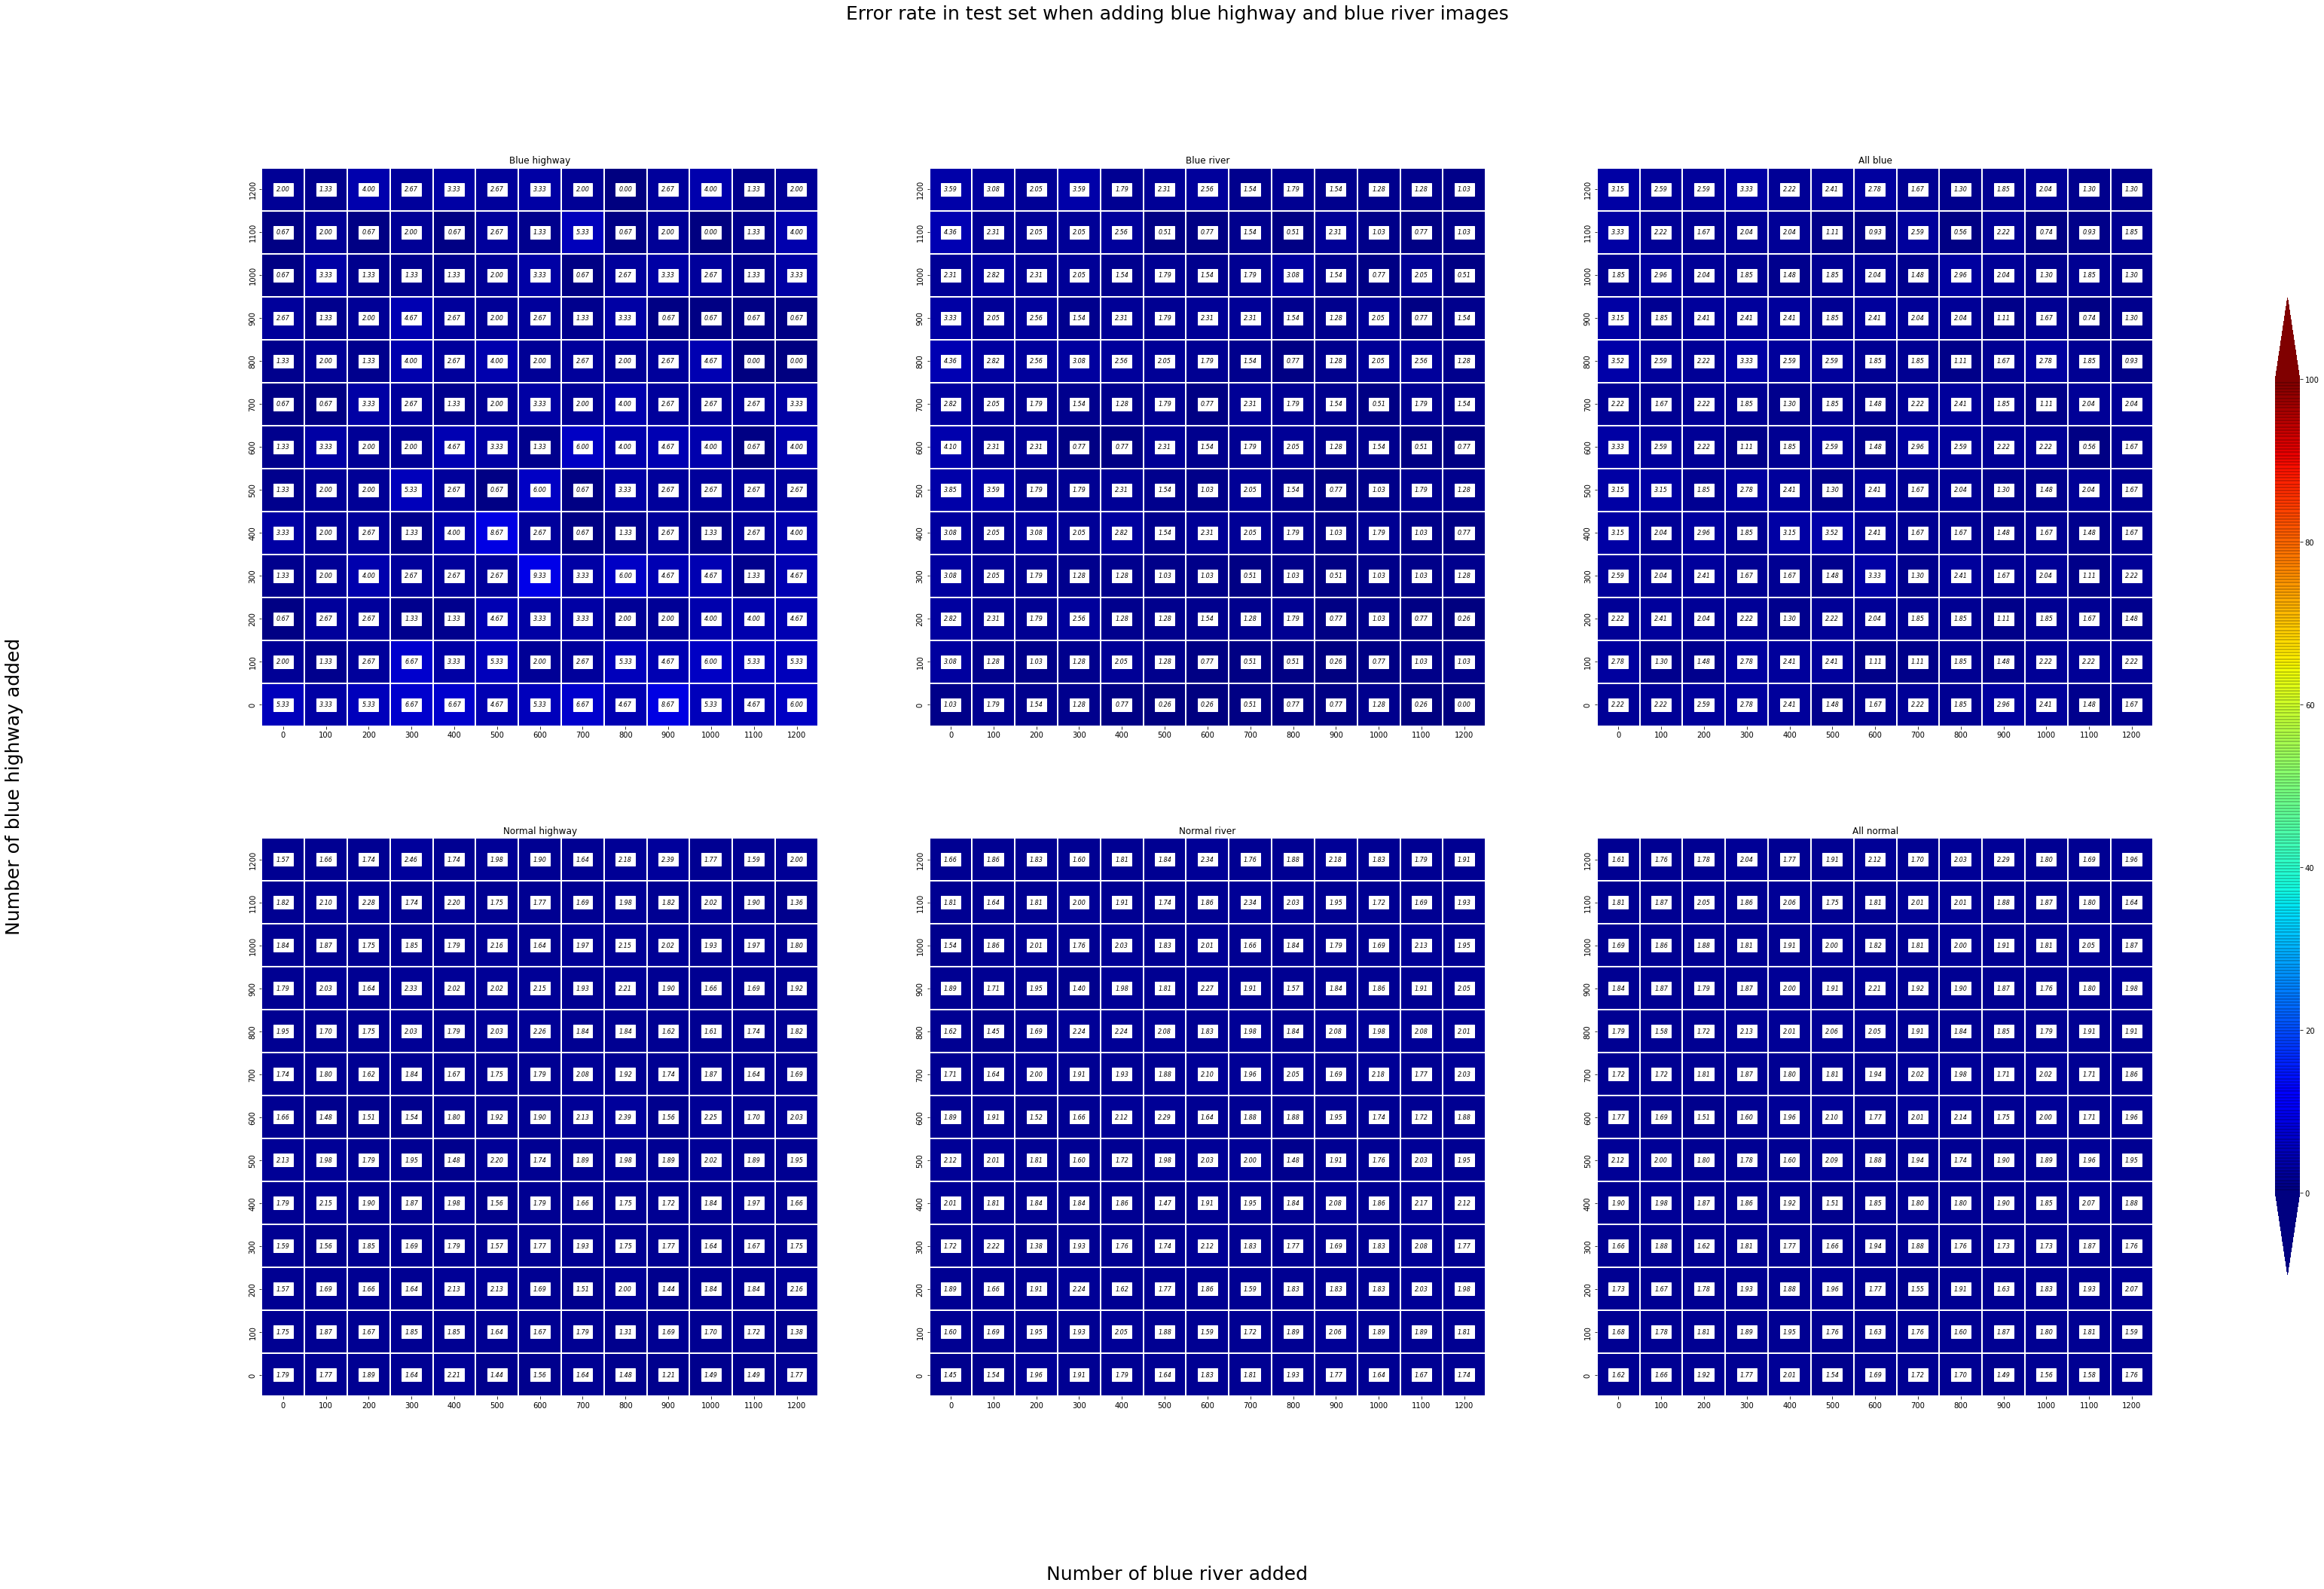

In [6]:
plot_heatmap_err_rate(error_rate, nbs_highway, nbs_river)

The above is the result of the model's cccuracy and the error rates of the image groups in the test set. From there we select a pair of number of HW and RV optimally to add the original dataset. We will take the pair [800, 600].

## Evaluations

Now we turn to a new experiment, it combines both Data augmentation and Loss function selection. Here we will use the Loss CE function and two losses to reduce Bias: Biascon and Biasbal. We designed 17 configs corresponding to the number of HW and RV images added and the type of loss function used. We assess each of these configs by metrics that is the error rate of the image groups in the test set. Finally we saved the results as a dataframe.

In [6]:
df = get_dataframe(path=save_path, model_name='ResNet18', nb_seeds=10)

In [7]:
df.head(5)

,Model name,Seed,Config,Metric name,Metric value,Mapping
0,ResNet18,1,Config_1,Err_bl_hw,0.000000,"(0, 0, CE)"
1,ResNet18,1,Config_1,Err_bl_rv,5.128205,"(0, 0, CE)"
2,ResNet18,1,Config_1,Err_bl,3.703704,"(0, 0, CE)"
3,ResNet18,1,Config_1,Err_nor,1.254181,"(0, 0, CE)"
4,ResNet18,1,Config_1,Err_nor_hw,0.819672,"(0, 0, CE)"


In [8]:
df.to_csv('dataframe.csv')

In [33]:
bl_hw = df[df['Metric name']=="Err_bl_hw"]
bl_rv = df[df['Metric name']=="Err_bl_rv"]
bl = df[df['Metric name']=="Err_bl"]
nor = df[df['Metric name']=="Err_nor"]
nor_hw = df[df['Metric name']=="Err_nor_hw"]
nor_rv = df[df['Metric name']=="Err_nor_rv"]
hw = df[df['Metric name']=="Err_hw"]
rv = df[df['Metric name']=="Err_rv"]

In [34]:
array = ["Err_bl", "Err_nor"]
bl_nor = df[df['Metric name'].isin(array)]

### Blue highway

In [39]:
fig = px.violin(bl_hw, y='Metric value', x='Metric name', color='Config', box=False, height=500, width=1200)
fig.show()

### Blue river

In [41]:
fig = px.violin(bl_rv, y='Metric value', x='Metric name', color='Config', box=False, height=500, width=1200)
fig.show()

### All blue

In [42]:
fig = px.violin(bl, y='Metric value', x='Metric name', color='Config', box=False, height=500, width=1200)
fig.show()

### All normal

In [43]:
fig = px.violin(nor, y='Metric value', x='Metric name', color='Config', box=False, height=500, width=1200)
fig.show()

### Normal highway

In [44]:
fig = px.violin(nor_hw, y='Metric value', x='Metric name', color='Config', box=False, height=500, width=1200)
fig.show()

### Normal river

In [45]:
fig = px.violin(nor_rv, y='Metric value', x='Metric name', color='Config', box=False, height=500, width=1200)
fig.show()

### All highway

In [46]:
fig = px.violin(hw, y='Metric value', x='Metric name', color='Config', box=False, height=500, width=1200)
fig.show()

### All river

In [47]:
fig = px.violin(rv, y='Metric value', x='Metric name', color='Config', box=False, height=500, width=1200)
fig.show()

### Blue and normal

In [48]:
fig = px.violin(bl_nor, y='Metric value', x='Metric name', color='Config', box=False, height=500, width=1200)
fig.show()

In [49]:
fig = px.violin(bl_nor, y='Metric value', color='Metric name', x='Config', box=False, height=500, width=1200)
fig.show()

We see that in this case, the two losses of Biascon and Biasbal do not really help reduce the error rate of blue images. However, we can see that regardless of whether using the Loss CE, Biascon or Biasbal function, the Augmentation data method has helped reduce the error rate for minority image groups that are blue images in the test set.